In [1]:
import os
import re
import random
import gc
import warnings
from collections import namedtuple
from math import sqrt
import json
import numpy as np
import pandas as pd
import lightgbm as lgb
import sklearn
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import cohen_kappa_score, make_scorer, mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import ks_2samp

pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : None
python           : 3.7.1.final.0
python-bits      : 64
OS               : Windows
OS-release       : 7
machine          : AMD64
processor        : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : None.None

pandas           : 0.25.3
numpy            : 1.17.4
pytz             : 2019.3
dateutil         : 2.8.1
pip              : 19.3.1
setuptools       : 39.0.1
Cython           : None
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.10.3
IPython          : 7.10.2
pandas_datareader: None
bs4              : None
bottleneck       : None
fastparquet      : None
gcsfs            : None
lxml.etree       : None
matplotlib       : 3

In [2]:
def _log(str):
    os.system(f'echo \"{str}\"')
    print(str)

In [3]:
INPUT_ROOT = '../input/data-science-bowl-2019'
JOIN_KEY = ['installation_id', 'game_session', 'title']
TARGET = 'accuracy_group'
FEATURES = {
    'event_id', 
    'game_session', 
    'timestamp', 
    'installation_id', 
    'event_count',
    'event_code', 
    'game_time', 
    'title', 
    'type', 
    'world',
    'event_data'
}
EVENT_CODES = ['2000', '2010', '2020', '2025', '2030', '2035', '2040', '2050', '2060', '2070', '2075', '2080', '2081', '2083', '3010', '3020', '3021', '3110', '3120', '3121', '4010', '4020', '4021', '4022', '4025', '4030', '4031', '4035', '4040', '4045', '4050', '4070', '4080', '4090', '4095', '4100', '4110', '4220', '4230', '4235', '5000', '5010']
SEED = 31

In [4]:
def _init():
    # Characters such as empty strings '' or numpy.inf are considered NA values
    pd.set_option('use_inf_as_na', True)
    pd.set_option('display.max_columns', 999)
    pd.set_option('display.max_rows', 999)
    
    
_init()

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


seed_everything(SEED)

In [6]:
RANDOM_VALUES = []
for _ in range(4000):
    RANDOM_VALUES.append(random.random())
    
_log(f'RANDOM_VALUES={RANDOM_VALUES[:20]}')

RANDOM_VALUES=[0.01227824739797545, 0.11239886108023578, 0.39283736155074256, 0.683864273453267, 0.13869093321463077, 0.11244356285938728, 0.23180235707395025, 0.7575924853950116, 0.1474012209602784, 0.7406551989400061, 0.6621666555152632, 0.13657852434493012, 0.5356617475477887, 0.4477509299372836, 0.41257008317805066, 0.9963436915955056, 0.0931113892655685, 0.02036645837312856, 0.9398019156431335, 0.40294581161091647]


In [7]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk(INPUT_ROOT):
    for filename in filenames:
        _log(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/data-science-bowl-2019/train_labels.csv
../input/data-science-bowl-2019/test.csv
../input/data-science-bowl-2019/train.csv
../input/data-science-bowl-2019/train_labels.csv.zip
../input/data-science-bowl-2019/test.csv.zip
../input/data-science-bowl-2019/train.csv.zip


In [8]:
%%time
train_raw = pd.read_csv(f'{INPUT_ROOT}/train.csv', usecols=FEATURES)
train_labels = pd.read_csv(f'{INPUT_ROOT}/train_labels.csv', usecols=JOIN_KEY + [TARGET])
test_raw = pd.read_csv(f'{INPUT_ROOT}/test.csv', usecols=FEATURES)
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17690 entries, 0 to 17689
Data columns (total 4 columns):
game_session       17690 non-null object
installation_id    17690 non-null object
title              17690 non-null object
accuracy_group     17690 non-null int64
dtypes: int64(1), object(3)
memory usage: 552.9+ KB
CPU times: user 41.9 s, sys: 7.45 s, total: 49.3 s
Wall time: 50.5 s


# Add labels to train data

In [9]:
def _remove_unlabelled_data(train_raw, train_labels):
    return train_raw[train_raw['installation_id'].isin(train_labels['installation_id'].unique())]


train_raw = _remove_unlabelled_data(train_raw, train_labels)

In [10]:
%%time
def _add_labels(train_raw, train_labels, on):
    return pd.merge(train_raw, train_labels, on=on, how='left')


train_raw = _add_labels(train_raw, train_labels, on=JOIN_KEY)
del train_labels

CPU times: user 3.43 s, sys: 582 ms, total: 4.01 s
Wall time: 4.02 s


# Extract event data JSON

In [11]:
def _concat_columns(df1, df2):
    """Concatenate the columns of two pandas dataframes in the order of the operands.
    Both dataframes must have the same number of rows.
    """
    assert len(df1) == len(df2)
    res = pd.concat([df1, df2.reindex(df1.index)], axis=1, join='inner')
    assert len(res) == len(df1)
    return res
    

def _extract_event_data(df, keep_cols, chunk_size=1000000):
    res = pd.DataFrame()
    _len = len(df)
    for i in tqdm(range(0, _len, chunk_size)):
        if i + chunk_size < _len:
            chunk = df[i:i + chunk_size].copy()
        else:
            chunk = df[i:].copy()
        ed = pd.io.json.json_normalize(chunk['event_data'].apply(json.loads)).add_prefix('ed.')
        ed = ed[keep_cols].astype(np.float32)
        chunk = _concat_columns(chunk, ed)
        # sort=False because not all rows have same fields in event_data
        res = pd.concat([res, chunk], ignore_index=True, sort=False)
    # this line is too slow and OOM error!
    #res[keep_cols] = res[keep_cols].fillna(-1).astype(np.float32)
    assert len(df) == len(res)
    return res


#keep_cols = ['ed.duration', 'ed.level', 'ed.round', 'ed.correct', 'ed.misses','ed.weight', 'ed.total_duration']
#keep_cols = ['ed.identifier', 'ed.duration', 'ed.level', 'ed.round', 'ed.correct', 'ed.misses','ed.weight', 'ed.total_duration', 'ed.source']
#train_raw = _extract_event_data(train_raw, keep_cols)
#test_raw = _extract_event_data(test_raw, keep_cols)

In [12]:
test_raw.info(max_cols=999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156414 entries, 0 to 1156413
Data columns (total 11 columns):
event_id           1156414 non-null object
game_session       1156414 non-null object
timestamp          1156414 non-null object
event_data         1156414 non-null object
installation_id    1156414 non-null object
event_count        1156414 non-null int64
event_code         1156414 non-null int64
game_time          1156414 non-null int64
title              1156414 non-null object
type               1156414 non-null object
world              1156414 non-null object
dtypes: int64(3), object(8)
memory usage: 97.1+ MB


In [13]:
train_raw.info(max_cols=999)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7734558 entries, 0 to 7734557
Data columns (total 12 columns):
event_id           object
game_session       object
timestamp          object
event_data         object
installation_id    object
event_count        int64
event_code         int64
game_time          int64
title              object
type               object
world              object
accuracy_group     float64
dtypes: float64(1), int64(3), object(8)
memory usage: 767.1+ MB


In [14]:
# All event ids in test set also exist in train set
#test_set = set(test_raw['event_id'])
#train_set = set(train_raw['event_id'])
#vs = test_set - train_set
#_log(f'{len(vs)} event_ids exist in test set but not train set.')

In [15]:
EVENT_IDS = sorted(list(set(train_raw['event_id']) | set(test_raw['event_id'])))
_log(f'{len(EVENT_IDS)} EVENT_IDS={EVENT_IDS}')

379 EVENT_IDS=['0086365d', '00c73085', '01ca3a3c', '022b4259', '02a42007', '0330ab6a', '0413e89d', '04df9b66', '05ad839b', '06372577', '070a5291', '08fd73f3', '08ff79ad', '0a08139c', '0ce40006', '0d18d96c', '0d1da71f', '0db6d71d', '119b5b02', '1325467d', '1340b8d7', '1375ccb7', '13f56524', '14de4c5d', '155f62a4', '1575e76c', '15a43e5b', '15ba1109', '15eb4a7d', '15f99afc', '160654fd', '16667cc5', '16dffff1', '17113b36', '19967db1', '1996c610', '1af8be29', '1b54d27f', '1bb5fbdb', '1beb320a', '1c178d24', '1cc7cfca', '1cf54632', '1f19558b', '222660ff', '2230fab4', '250513af', '25fa8af4', '262136f4', '26a5a3dd', '26fd2d99', '27253bdc', '28520915', '28a4eb9a', '28ed704e', '28f975ea', '29a42aea', '29bdd9ba', '29f54413', '2a444e03', '2a512369', '2b058fe3', '2b9272f4', '2c4e6db0', '2dc29e21', '2dcad279', '2ec694de', '2fb91ec1', '30614231', '30df3273', '31973d56', '3323d7e9', '33505eae', '3393b68b', '363c86c9', '363d3849', '36fa3ebe', '37937459', '37c53127', '37db1c2f', '37ee8496', '38074c54', '

In [16]:
TITLES = test_raw['title'].unique()
test_raw['title'].value_counts()

Bottle Filler (Activity)         112223
Scrub-A-Dub                       96619
Chow Time                         93142
Sandcastle Builder (Activity)     82132
Fireworks (Activity)              61032
Bug Measurer (Activity)           59886
Bubble Bath                       55264
Dino Drink                        53989
Dino Dive                         49368
Crystals Rule                     46867
Chicken Balancer (Activity)       45874
All Star Sorting                  45863
Flower Waterer (Activity)         43819
Happy Camel                       39806
Pan Balance                       38649
Watering Hole (Activity)          35367
Air Show                          27119
Egg Dropper (Activity)            25941
Leaf Leader                       25574
Cauldron Filler (Assessment)      23440
Mushroom Sorter (Assessment)      21962
Bird Measurer (Assessment)        20086
Cart Balancer (Assessment)        19235
Chest Sorter (Assessment)         17904
Crystal Caves - Level 2            1450


In [17]:
TYPES = test_raw['type'].unique()
test_raw['type'].value_counts()

Game          572260
Activity      466274
Assessment    102627
Clip           15253
Name: type, dtype: int64

In [18]:
WORLDS = test_raw['world'].unique()
test_raw['world'].value_counts()

MAGMAPEAK       511291
TREETOPCITY     332295
CRYSTALCAVES    311387
NONE              1441
Name: world, dtype: int64

In [19]:
#test_raw['ed.source'].value_counts()

In [20]:
#test_raw['ed.identifier'].value_counts()

In [21]:
vs = sorted(train_raw['event_code'].unique())
_log(f'{len(vs)} train_raw type={vs}')

42 train_raw type=[2000, 2010, 2020, 2025, 2030, 2035, 2040, 2050, 2060, 2070, 2075, 2080, 2081, 2083, 3010, 3020, 3021, 3110, 3120, 3121, 4010, 4020, 4021, 4022, 4025, 4030, 4031, 4035, 4040, 4045, 4050, 4070, 4080, 4090, 4095, 4100, 4110, 4220, 4230, 4235, 5000, 5010]


In [22]:
%%time
_prev = pd.to_datetime(pd.Series(['2019-08-06T05:22:41.147000000'])).astype(np.int64).values[0]
_next = pd.to_datetime(pd.Series(['2019-08-06T05:22:41.147000001'])).astype(np.int64).values[0]
assert _next - _prev == 1


def _transform_timestamp(df):
    vs = pd.to_datetime(df['timestamp'])
    df['timestamp'] = vs
    assert df['timestamp'].notna().all()
    df['timestamp_int'] = vs.astype(np.int64)
    assert df['timestamp_int'].notna().all()


_transform_timestamp(train_raw)
_transform_timestamp(test_raw)

CPU times: user 4.45 s, sys: 301 ms, total: 4.75 s
Wall time: 4.75 s


In [23]:
%%time
def _set_string_type(df, cols):
    df[cols] = df[cols].astype(str)
    return df


cols = ['event_code', 'timestamp']
train_raw = _set_string_type(train_raw, cols=cols)
test_raw = _set_string_type(test_raw, cols=cols)

CPU times: user 41 s, sys: 663 ms, total: 41.6 s
Wall time: 41.8 s


In [24]:
%%time
def _sort_it(df):
    return df.sort_values(by=['installation_id', 'timestamp'])


#train_raw = _sort_it(train_raw)
#test_raw = _sort_it(test_raw)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs


# Multiple accuracy groups per installation id
In the training set, you are provided the full history of gameplay data. In the test set, we have truncated the history after the start event of a single assessment, chosen randomly, for which you must predict the number of attempts. Note that the training set contains many installation_ids which never took assessments, whereas every installation_id in the test set made an attempt on at least one assessment.

In [25]:
vs = train_raw[train_raw[TARGET].notna()].groupby('installation_id', as_index=False)[TARGET].nunique()
vs

0       3
1       3
2       1
3       3
4       1
       ..
3609    2
3610    4
3611    2
3612    1
3613    2
Name: accuracy_group, Length: 3614, dtype: int64

# Train-test split not by time
Both train and test sets span the same time period.

In [26]:
#_log(f'train_raw[timestamp] is from {train_raw.timestamp.min()} to {train_raw.timestamp.max()}')
#_log(f'test_raw[timestamp] is from {test_raw.timestamp.min()} to {test_raw.timestamp.max()}')

In [27]:
#vs = train_raw[(train_raw['installation_id'] == '0006a69f') & (train_raw[TARGET].notna())].groupby(['game_session', 'title', TARGET], as_index=False)['timestamp'].max()
#vs = sorted(vs['timestamp'].values) 
#vs

In [28]:
#tmp = test_raw.groupby(['world', 'type'], as_index=False)['game_time'].quantile([.25, .5, .75], interpolation='lower')
#tmp.head()

In [29]:
train_raw.info(max_cols=999)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7734558 entries, 0 to 7734557
Data columns (total 13 columns):
event_id           object
game_session       object
timestamp          object
event_data         object
installation_id    object
event_count        int64
event_code         object
game_time          int64
title              object
type               object
world              object
accuracy_group     float64
timestamp_int      int64
dtypes: float64(1), int64(3), object(9)
memory usage: 826.1+ MB


In [30]:
test_raw.info(max_cols=999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156414 entries, 0 to 1156413
Data columns (total 12 columns):
event_id           1156414 non-null object
game_session       1156414 non-null object
timestamp          1156414 non-null object
event_data         1156414 non-null object
installation_id    1156414 non-null object
event_count        1156414 non-null int64
event_code         1156414 non-null object
game_time          1156414 non-null int64
title              1156414 non-null object
type               1156414 non-null object
world              1156414 non-null object
timestamp_int      1156414 non-null int64
dtypes: int64(3), object(9)
memory usage: 105.9+ MB


# Feature Engineering

In [31]:
def _key(s):
    return re.sub(r'[\W\s]', '', s).lower()


def _timestamp_cutoffs(df, TARGET):
    res = df[df[TARGET].notna()].copy().groupby(['game_session', 'title', TARGET], as_index=False)['timestamp_int'].max()
    res = sorted(res['timestamp_int'].values)
    return res

    
def _target_variable(df, TARGET):
    vs = df[TARGET].copy().dropna().unique()
    assert len(set(vs)) == 1
    return vs[0]
    

def _group_stats(df, col, titles, types, worlds, suffix):
    """Get percentile stats"""
    res = {}
    _percentiles = [0.25, 0.5, 0.75]
    defaults = {}
    qs = df[col].quantile(_percentiles, interpolation='lower').to_numpy()
    for i, q in enumerate(qs):
        percentile = f'p{int(_percentiles[i] * 100)}'
        defaults[percentile] = q
        k = f'{col}_{percentile}{suffix}'
        res[k] = np.float32([q])
    
    # initialize values
    for p in _percentiles:
        percentile = f'p{int(p * 100)}'
        for w in worlds:
            for t in types:
                k = f'{col}_{percentile}_{_key(w)}_{_key(t)}{suffix}'
                res[k] = np.float32([defaults[percentile]])

        for t in titles:
            k = f'{col}_{percentile}_{_key(t)}{suffix}' 
            res[k] = np.float32([defaults[percentile]])

    if len(worlds) != 0 and len(types) != 0:
        tmp = df.groupby(['world', 'type'], as_index=False)[col].quantile(_percentiles, interpolation='lower')
        i = 0
        for row in tmp.itertuples(index=False):
            percentile = f'p{int(_percentiles[i % 3] * 100)}'
            k = f'{col}_{percentile}_{_key(row[0])}_{_key(row[1])}{suffix}'
            i += 1
            if k in res and not np.isnan(row[2]):
                res[k] = np.float32([row[2]])
    
    if len(titles) != 0:
        tmp = df.groupby(['title'], as_index=False)[col].quantile(_percentiles, interpolation='lower')
        i = 0
        for row in tmp.itertuples(index=False):
            percentile = f'p{int(_percentiles[i % 3] * 100)}'
            k = f'{col}_{percentile}_{_key(row[0])}{suffix}'
            i += 1
            if k in res and not np.isnan(row[1]):
                res[k] = np.float32([row[1]])
    return res    
    

def _game_session_stats(df, col, titles, types, worlds, suffix):
    """Deprecated."""
    res = {}
    _default = -1
    # initialize values
    k = f'{col}_gamesession_p50{suffix}'
    res[k] = np.float32([_default])
    for w in worlds:
        for t in types:
            k = f'{col}_gamesession_{_key(w)}_{_key(t)}_p50{suffix}'
            res[k] = np.float32([_default])

    for t in titles:
        k = f'{col}_gamesession_{_key(t)}_p50{suffix}' 
        res[k] = np.float32([_default])

    tmp = df.groupby(['game_session'], as_index=False)[col].quantile(.75, interpolation='lower')
    k = f'{col}_gamesession_p50{suffix}'
    if k in res and not tmp[col].isna().all():
        v = tmp[col].median()
        res[k] = np.float32([v])

    if len(worlds) != 0 and len(types) != 0:
        tmp = df.groupby(['game_session', 'world', 'type'], as_index=False)[col].quantile(.75, interpolation='lower')
        tmp.dropna(subset=[col], inplace=True)
        tmp = tmp.groupby(['world', 'type'], as_index=False)[col].median()
        for row in tmp.itertuples(index=False):
            k = f'{col}_gamesession_{_key(row[0])}_{_key(row[1])}_p50{suffix}'
            if k in res:
                res[k] = np.float32([row[2]])

    if len(titles) != 0:
        tmp = df.groupby(['game_session', 'title'], as_index=False)[col].quantile(.75, interpolation='lower')
        tmp.dropna(subset=[col], inplace=True)
        tmp = tmp.groupby(['title'], as_index=False)[col].median()
        for row in tmp.itertuples(index=False):
            k = f'{col}_gamesession_{_key(row[0])}_p50{suffix}'
            if k in res:
                res[k] = np.float32([row[1]])
    
    #qs = vs.quantile([0.25, 0.5, 0.75], interpolation='lower').to_numpy()    
    return res


def _count(df, col, values, suffix):
    res = {}
    for v in values:
        res[f'{col}_{_key(v)}{suffix}'] = np.int32([0])
    
    if len(values) != 0:
        tmp = df.groupby([col], as_index=False).count()
        for row in tmp.itertuples(index=False):
            res[f'{col}_{_key(row[0])}{suffix}'] = np.int32([row[1]])
    
    return res
    

def _event_id_features(df, event_ids, titles, types, worlds, suffix):
    res = {}
    # initialize counts
    for eid in event_ids:
        res[f'eid_{eid}{suffix}'] = np.int32([0])      
        for w in worlds:
            for t in types:
                res[f'eid_{eid}_{_key(w)}_{_key(t)}{suffix}'] = np.int32([0])
            
        for t in titles:
            res[f'eid_{eid}_{_key(t)}{suffix}'] = np.int32([0])
                      
    tmp = df.groupby(['event_id'], as_index=False).count()
    for row in tmp.itertuples(index=False):
        res[f'eid_{row[0]}{suffix}'] = np.int32([row[1]])
        
    if len(worlds) != 0 and len(types) != 0:
        tmp = df.groupby(['event_id', 'world', 'type'], as_index=False).count()
        for row in tmp.itertuples(index=False):
            k = f'eid_{row[0]}_{_key(row[1])}_{_key(row[2])}{suffix}'
            if k in res:
                res[k] = np.int32([row[3]])

    if len(titles) != 0:
        tmp = df.groupby(['event_id', 'title'], as_index=False).count()
        for row in tmp.itertuples(index=False):
            k = f'eid_{row[0]}_{_key(row[1])}{suffix}'
            if k in res:
                res[k] = np.int32([row[2]])
        
    return res


def _event_code_features(df, event_codes, titles, types, worlds, suffix):
    res = {}
    # initialize counts
    for code in event_codes:
        res[f'event_{code}{suffix}'] = np.int32([0])
        for w in worlds:
            for t in types:
                res[f'event_{code}_{_key(w)}_{_key(t)}{suffix}'] = np.int32([0])
            
        for t in titles:
            res[f'event_{code}_{_key(t)}{suffix}'] = np.int32([0])
        
    tmp = df.groupby(['event_code'], as_index=False).count()
    for row in tmp.itertuples(index=False):
        res[f'event_{row[0]}{suffix}'] = np.int32([row[1]])
        
    if len(worlds) != 0 and len(types) != 0:
        tmp = df.groupby(['event_code', 'world', 'type'], as_index=False).count()
        for row in tmp.itertuples(index=False):
            k = f'event_{row[0]}_{_key(row[1])}_{_key(row[2])}{suffix}'
            if k in res:
                res[k] = np.int32([row[3]])

    if len(titles) != 0:
        tmp = df.groupby(['event_code', 'title'], as_index=False).count()
        for row in tmp.itertuples(index=False):
            k = f'event_{row[0]}_{_key(row[1])}{suffix}'
            if k in res:
                res[k] = np.int32([row[2]])
        
    return res


def _event_data_features(df, suffix):
    res = {}
    res[f'ed_duration{suffix}'] = np.int32(df['ed.duration'].fillna(0).max())
    res[f'ed_total_duration{suffix}'] = np.int32(df['ed.total_duration'].fillna(0).max())
    res[f'ed_level{suffix}'] = np.int32(df['ed.level'].fillna(0).max())
    res[f'ed_round{suffix}'] = np.int32(df['ed.round'].fillna(0).max())
    res[f'ed_correct{suffix}'] = np.int32(df['ed.correct'].fillna(0).max())
    res[f'ed_misses{suffix}'] = np.int32(df['ed.misses'].fillna(0).max())
    res[f'ed_weight{suffix}'] = np.int32(df['ed.weight'].fillna(0).max())
    res[f'ed_source_resources{suffix}'] = np.int32([sum(df['ed.source'] == 'resources')])
    res[f'ed_source_right{suffix}'] = np.int32([sum(df['ed.source'] == 'right')])
    res[f'ed_source_left{suffix}'] = np.int32([sum(df['ed.source'] == 'left')])
    res[f'ed_source_scale{suffix}'] = np.int32([sum(df['ed.source'] == 'scale')])
    res[f'ed_source_middle{suffix}'] = np.int32([sum(df['ed.source'] == 'middle')])
    res[f'ed_source_heaviest{suffix}'] = np.int32([sum(df['ed.source'] == 'Heaviest')])
    res[f'ed_source_heavy{suffix}'] = np.int32([sum(df['ed.source'] == 'Heavy')])
    res[f'ed_source_lightest{suffix}'] = np.int32([sum(df['ed.source'] == 'Lightest')])
    n = 0
    for i in range(1, 13):
        n += sum(df['ed.source'] == str(i))
    res[f'ed_source_numbered{suffix}'] = np.int32([n])
    res[f'ed_id_dot{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('Dot_', regex=False))])
    res[f'ed_id_buddy{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('Buddy_', regex=False))])
    res[f'ed_id_cleo{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('Cleo_', regex=False))])
    res[f'ed_id_mom{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('Mom_', regex=False))])
    res[f'ed_id_sid{suffix}'] = np.int32([sum(df['ed.identifier'].str.contains('sid_', regex=False))])
    positives = {'Dot_SoCool', 'Dot_GreatJob', 'ohWow', 'wowSoCool', 'thatLooksSoCool', 'tub_success', 
                 'water_success', 'soap_success', 'Dot_Amazing', 'Dot_WhoaSoCool', 'Dot_ThatsIt', 'youDidIt_1305',
                 'SFX_completedtask', 'Cleo_AmazingPowers', 'RIGHTANSWER1', 'Dot_Awesome', 'greatJob_1306', 'YouDidIt',
                 'RIGHTANSWER3', 'RIGHTANSWER2', 'INSTRCOMPLETE', 'AWESOME', 'WayToGoTeam', 'Dot_NiceWorkAllMatch',
                 'GreatFlying', 'WeDidItOneRoundLeft', 'Cleo_AweOfYourSkills', 'Dot_NiceWork'}
    n_pos = 0
    for p in positives:
        n_pos += sum(df['ed.identifier'].str.contains(p, regex=False))
    res[f'ed_id_positive{suffix}'] = np.int32([n_pos])
    negatives = {'Dot_Uhoh', 'Dot_UhOh', 'Dot_NeedTryAgain', 'IncorrectTooHeavy', 'Dot_GoLower', 'Buddy_TryDifferentNest',
                 'Cleo_BowlTooLight', 'Dot_GoHigher', 'Dot_SoLow', 'Dot_SoHigh', 'Dot_WhoopsTooShort', 'IncorrectTooLight',
                 'NOT_THAT_HEAVY', 'Dot_UhOhTooTall', 'ADD_MORE_WEIGHT', 'wrong1', 'tryAgain1', 'Dot_TryWeighingAgain',
                 'Cleo_RememberHeavierBowl', 'Dot_Whoops', 'Dot_NotBalanced', 'Mom_TooManyContainers',
                 'WrongOver', 'Mom_TooMuchWater', 'Dot_ThatBucketNotRight', 'Dot_TryAgain', 'wrongFewer', 'WrongBetweenCliff',
                 'Mom_NeedMoreContainers', 'Dot_Try', 'Dot_HmTooSmall'}
    n_neg = 1
    for ne in negatives:
        n_neg += sum(df['ed.identifier'].str.contains(ne, regex=False))
    res[f'ed_id_negative{suffix}'] = np.int32([n_neg])
    res[f'ed_id_positive_ratio{suffix}'] = np.float32([n_pos / n_neg])
    return res
    
    
def _worlds_picked():
    return ['MAGMAPEAK', 'TREETOPCITY', 'CRYSTALCAVES']


def _titles_picked():
    return ['Cauldron Filler (Assessment)', 'Mushroom Sorter (Assessment)', 'Bird Measurer (Assessment)',
            'Cart Balancer (Assessment)', 'Chest Sorter (Assessment)'
           ]
    

def _types_picked():
    return ['Assessment', 'Game']
    
        
def _features_map(df, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS, suffix=''):
    res = {}
    worlds = _worlds_picked()
    titles = _titles_picked()
    types = _types_picked()
    #cols = ['game_time', 'event_count', 'ed.duration', 'ed.level', 'ed.round','ed.correct','ed.misses','ed.weight','ed.total_duration']
    #for col in cols:
     #   res.update(_group_stats(df, col, titles=titles, types=types, worlds=worlds, suffix=suffix))
    
    res.update(_count(df, col='type', values=TYPES, suffix=suffix))
    res.update(_count(df, col='world', values=WORLDS, suffix=suffix))
    res.update(_count(df, col='title', values=TITLES, suffix=suffix))
    res.update(_event_code_features(df, EVENT_CODES, titles=titles, types=types, worlds=worlds, suffix=suffix))
    res.update(_event_id_features(df, EVENT_IDS, titles=titles, types=types, worlds=worlds, suffix=suffix))
    #res.update(_event_data_features(df, suffix))
    return res


def _features(df, installation_id, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS):
    res = {}
    if TARGET in df.columns:
        res[TARGET] = np.int16([_target_variable(df, TARGET)])
    res['installation_id'] = [installation_id]    
    res.update(_features_map(df, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS))
    return pd.DataFrame.from_dict(res)


def _preprocess(raw, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS):
    res = pd.DataFrame()
    raw = raw.set_index('installation_id', drop=False)
    iids = raw['installation_id'].unique()
    prev_len = None
    prev_cols = None
    rv = 0
    for iid in tqdm(iids):
        whole = raw.loc[[iid]].copy()  # double square brackets return a Dataframe!
        whole = whole.set_index('timestamp_int', drop=False)
        dfs = []
        if TARGET in whole.columns:
            # train set: each installation id may contribute one or more examples.
            _prev = pd.to_datetime(pd.Series(['1999-01-01T05:22:41.147000000'])).astype(np.int64).values[0]
            for _curr in _timestamp_cutoffs(whole, TARGET):
                df = whole.loc[_prev + 1:_curr]
                dfs.append(df)
                _prev = _curr
        else:
            # test set: each installation id contributes one example.
            dfs.append(whole)
        j = -1
        if len(dfs) > 1:
            j = int(RANDOM_VALUES[rv])
            rv += 1
        for i, df in enumerate(dfs):
            if TARGET in df.columns:
                installation_id = f'{iid}_{i + 1}'
            else:
                installation_id = iid
            ex = _features(df, installation_id, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS)
            if TARGET in df.columns:
                if i == j:
                    ex['_is_val'] = 0  # validation set
                else:
                    ex['_is_val'] = -1
            prev_len = len(ex.columns) if prev_len is None else prev_len
            prev_cols = set(ex.columns) if prev_cols is None else prev_cols
            if len(ex.columns) != prev_len:
                _diff = set(ex.columns) - prev_cols
                raise ValueError(f'Number of columns must be the same. Difference found={_diff}')
            prev_len = len(ex.columns)
            res = pd.concat([res, ex], ignore_index=True)
    return res



In [32]:
test = _preprocess(test_raw, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS)

100%|██████████| 1000/1000 [04:39<00:00,  3.58it/s]


In [33]:
test.info(max_cols=9999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5105 columns):
installation_id                          1000 non-null object
type_clip                                1000 non-null int32
type_game                                1000 non-null int32
type_activity                            1000 non-null int32
type_assessment                          1000 non-null int32
world_none                               1000 non-null int32
world_magmapeak                          1000 non-null int32
world_crystalcaves                       1000 non-null int32
world_treetopcity                        1000 non-null int32
title_welcometolostlagoon                1000 non-null int32
title_magmapeaklevel1                    1000 non-null int32
title_magmapeaklevel2                    1000 non-null int32
title_crystalcaveslevel1                 1000 non-null int32
title_chowtime                           1000 non-null int32
title_balancingact                   

In [34]:
assert test.notna().all(axis=None)
del test_raw
gc.collect()
test.head(20)

installation_id  type_clip  type_game  type_activity  type_assessment  \
0         00abaee7         14        373            454               27   
1         01242218         29       1089           1356              245   
2         017c5718          6          0            143                1   
3         01a44906         10         78            145                1   
4         01bc6cb6         17        708            226                1   
5         02256298          6        296            515               16   
6         0267757a         13        784             90                1   
7         027e7ce5         17        376           1047              346   
8         02a29f99         10       1131            371              201   
9         0300c576         15          8              0                1   
10        03885368          3         58             55                1   
11        03ac279b          7        163            277                1   
12        03e33699         16        120            205               67   
13        048e7427          4        117            134                1   
14        04a7bc3f         10         92            115                1   
15        04d31500          5          0            111               36   
16        0500e23b          3          0             80                1   
17        0512bf0e         11        462            374               28   
18        0525589b          3        138             78                1   
19        05488e26          2          0              0                1   

    world_none  world_magmapeak  world_crystalcaves  world_treetopcity  \
0            1              241                 253                373   
1            2              848                 885                984   
2            4                0                   0                146   
3            3                0                   0                231   
4            3                3                 522                424   
5            0              262                 570                  1   
6            3              188                 386                311   
7            1              392                 574                819   
8            0              743                 313                657   
9            1                2                  18                  3   
10           0              114                   2                  1   
11           0              163                   0                285   
12           1                2                  34                371   
13           1                0                 255                  0   
14           2                3                 213                  0   
15           0               55                  25                 72   
16           1               83                   0                  0   
17           3               29                 281                562   
18           0                0                 220                  0   
19           1                0                   2                  0   

    title_welcometolostlagoon  title_magmapeaklevel1  title_magmapeaklevel2  \
0                           1                      1                      1   
1                           2                      2                      2   
2                           4                      0                      0   
3                           3                      0                      0   
4                           3                      2                      1   
5                           0                      0                      2   
6                           3                      2                      2   
7                           1                      1                      3   
8                           0                      1                      2   
9                           1                      1         

# FE: train set

In [35]:
# budget of 4 seconds per iteration, or 4 hours total.
train = _preprocess(train_raw, EVENT_CODES, EVENT_IDS, TITLES, TYPES, WORLDS)

100%|██████████| 3614/3614 [3:19:45<00:00,  3.32s/it]     


In [36]:
train.info(max_cols=9999)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17690 entries, 0 to 17689
Data columns (total 5107 columns):
accuracy_group                           17690 non-null int16
installation_id                          17690 non-null object
type_clip                                17690 non-null int32
type_game                                17690 non-null int32
type_activity                            17690 non-null int32
type_assessment                          17690 non-null int32
world_none                               17690 non-null int32
world_magmapeak                          17690 non-null int32
world_crystalcaves                       17690 non-null int32
world_treetopcity                        17690 non-null int32
title_welcometolostlagoon                17690 non-null int32
title_magmapeaklevel1                    17690 non-null int32
title_magmapeaklevel2                    17690 non-null int32
title_crystalcaveslevel1                 17690 non-null int32
title_chowtime      

In [37]:
assert train.notna().all(axis=None)
tmp = train.groupby(['_is_val'], as_index=False)['installation_id'].count()
assert tmp.iloc[1]['installation_id'] >= 2000
tmp.head()

_is_val  installation_id
0       -1            15103
1        0             2587

In [38]:
del train_raw, tmp
gc.collect()
train.head(10)

accuracy_group installation_id  type_clip  type_game  type_activity  \
0               3      0006a69f_1         11        284            352   
1               0      0006a69f_2          3        241            204   
2               3      0006a69f_3          0          0              0   
3               2      0006a69f_4         10        320            547   
4               3      0006a69f_5          4        266            115   
5               3      0006c192_1         15        633            894   
6               0      0006c192_2         13          4            312   
7               2      0006c192_3          2          6              0   
8               3      00129856_1          0          0              0   
9               2      001d0ed0_1          6          0              0   

   type_assessment  world_none  world_magmapeak  world_crystalcaves  \
0               48           2              235                   0   
1               87           0                0                   0   
2               35           0                0                   0   
3               59           1              493                   0   
4               32           0                0                   0   
5               24           3             1339                  83   
6              119           1                4                 123   
7              200           0                0                   0   
8               43           0                0                   0   
9               64           1                0                   0   

   world_treetopcity  title_welcometolostlagoon  title_magmapeaklevel1  \
0                458                          2                      1   
1                535                          0                      0   
2                 35                          0                      0   
3                442                          1                      1   
4                417                          0                      0   
5                141                          3                      2   
6                320                          1                      0   
7                208                          0                      0   
8                 43                          0                      0   
9                 69                          1                      0   

   title_magmapeaklevel2  title_crystalcaveslevel1  title_chowtime  \
0                      0                         0               0   
1                      0                         0               0   
2                      0                         0               0   
3                      1                         0               0   
4                      0                         0               0   
5                      2                         1              82   
6                      1                         2               0   
7                      0                         0               0   
8                      0                         0               0   
9                      0                         0               0   

   title_balancingact  title_crystalcaveslevel2  title_treetopcitylevel1  \
0                   0                         0                        1   
1                   0                         0                        0   
2                   0                         0                        0   
3                   0                         0                        1   
4                   0                         0                        0   
5                   0                         0                        3   
6                   2                         2                        0   
7                   0                         0                        0   
8                   0                         0                        0   
9                   0                         0             

In [39]:
train.to_parquet('train.parquet')
test.to_parquet('test.parquet')
_log(os.listdir("."))

['train.parquet', 'test.parquet', 'train_scaled.parquet', 'submission.csv', 'test_scaled.parquet', 'dsbowl19-preprocess.ipynb', 'dsbowl19-lgb.ipynb', '.ipynb_checkpoints']


# Standardization

In [40]:
%%time
train = pd.read_parquet('train.parquet')
test = pd.read_parquet('test.parquet')

CPU times: user 16.5 s, sys: 1.84 s, total: 18.3 s
Wall time: 2.32 s


In [41]:
def _log_transform(df, cols):
    df[cols] = np.float32(np.log(df[cols] + 1))


#cols = list(set(test.columns.values) - {'installation_id'})
#_log_transform(train, cols)
#_log_transform(test, cols)
#train.head()

In [42]:
%%time
def _scaling(dfs, cols, scaler=None):
    scaler = sklearn.preprocessing.RobustScaler() if scaler is None else scaler
    scaler.fit(dfs[0][cols])
    for df in dfs:
        df[cols] = np.float32(scaler.transform(df[cols]))
        assert df.notna().all(axis=None)


#scaler = sklearn.preprocessing.PowerTransformer()
cols = list(set(test.columns.values) - {'installation_id', '_is_val'})
_scaling([train, test], cols)
train.head()

CPU times: user 5min 34s, sys: 4min 25s, total: 9min 59s
Wall time: 10min 1s


accuracy_group installation_id  type_clip  type_game  type_activity  \
0               3      0006a69f_1       2.00   0.882353       1.696429   
1               0      0006a69f_2       0.00   0.701681       0.815476   
2               3      0006a69f_3      -0.75  -0.310924      -0.398810   
3               2      0006a69f_4       1.75   1.033613       2.857143   
4               3      0006a69f_5       0.25   0.806723       0.285714   

   type_assessment  world_none  world_magmapeak  world_crystalcaves  \
0         0.285714         2.0         2.043478           -0.066225   
1         1.678571         0.0         0.000000           -0.066225   
2        -0.178571         0.0         0.000000           -0.066225   
3         0.678571         1.0         4.286956           -0.066225   
4        -0.285714         0.0         0.000000           -0.066225   

   world_treetopcity  title_welcometolostlagoon  title_magmapeaklevel1  \
0            2.86250                        2.0                    1.0   
1            3.34375                        0.0                    0.0   
2            0.21875                        0.0                    0.0   
3            2.76250                        1.0                    1.0   
4            2.60625                        0.0                    0.0   

   title_magmapeaklevel2  title_crystalcaveslevel1  title_chowtime  \
0                    0.0                       0.0             0.0   
1                    0.0                       0.0             0.0   
2                    0.0                       0.0             0.0   
3                    1.0                       0.0             0.0   
4                    0.0                       0.0             0.0   

   title_balancingact  title_crystalcaveslevel2  title_treetopcitylevel1  \
0                 0.0                       0.0                      1.0   
1                 0.0                       0.0                      0.0   
2                 0.0                       0.0                      0.0   
3                 0.0                       0.0                      1.0   
4                 0.0                       0.0                      0.0   

   title_allstarsorting  title_costumebox  title_fireworksactivity  \
0                 153.0               2.0                     84.0   
1                   0.0               0.0                      0.0   
2                   0.0               0.0                      0.0   
3                  50.0               1.0                    215.0   
4                   0.0               0.0                      0.0   

   title_12monkeys  title_liftingheavythings  title_cartbalancerassessment  \
0              1.0                       0.0                           0.0   
1              0.0                       0.0                           0.0   
2              0.0                       0.0                           0.0   
3              1.0                       0.0                           0.0   
4              0.0                       0.0                           0.0   

   title_crystalcaveslevel3  title_eggdropperactivity  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   title_bugmeasureractivity  title_sandcastlebuilderactivity  title_dinodive  \
0                        0.0                            102.0             0.0   
1                      204.0                              0.0             0.0   
2                        0.0                              0.0             0.0   
3                        0.0                             59.0             0.0   
4                      115.0                              0.0             0.0   

   title_cauldronfillerassessment  title_scrubadub  \
0                             0.0 

In [43]:
train.to_parquet('train_scaled.parquet')
test.to_parquet('test_scaled.parquet')
_log(os.listdir("."))

['train.parquet', 'test.parquet', 'train_scaled.parquet', 'submission.csv', 'test_scaled.parquet', 'dsbowl19-preprocess.ipynb', 'dsbowl19-lgb.ipynb', '.ipynb_checkpoints']


# Feature selection
[KS Test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)

In [7]:
%%time
train = pd.read_parquet('train_scaled.parquet')
test = pd.read_parquet('test_scaled.parquet')

Wall time: 3.35 s


In [8]:
def _select_features(df1, df2, features, alpha):
    res = []
    for f in tqdm(features):
        if ks_2samp(df1[f], df2[f]).pvalue > alpha:
            res.append(f)
    return res


ALPHA = 0.2
features = set(test.columns.values) - {'installation_id', '_is_val'}
PREDICTORS = _select_features(train, test, features, ALPHA)

100%|█████████████████████████████████████████████| 5104/5104 [00:09<00:00, 530.47it/s]


In [9]:
dropped = sorted(list(features - set(PREDICTORS)))
PREDICTORS = sorted(PREDICTORS)
_log(f'alpha={ALPHA}, keep {len(PREDICTORS)}/{len(features)} features, drop {len(dropped)} features.\nkeep={PREDICTORS}')

alpha=0.2, keep 4142/5104 features, drop 962 features.
keep=['eid_0086365d_birdmeasurerassessment', 'eid_0086365d_cartbalancerassessment', 'eid_0086365d_cauldronfillerassessment', 'eid_0086365d_chestsorterassessment', 'eid_0086365d_crystalcaves_assessment', 'eid_0086365d_magmapeak_assessment', 'eid_0086365d_magmapeak_game', 'eid_0086365d_mushroomsorterassessment', 'eid_0086365d_treetopcity_assessment', 'eid_0086365d_treetopcity_game', 'eid_00c73085_birdmeasurerassessment', 'eid_00c73085_cartbalancerassessment', 'eid_00c73085_cauldronfillerassessment', 'eid_00c73085_chestsorterassessment', 'eid_00c73085_crystalcaves_assessment', 'eid_00c73085_crystalcaves_game', 'eid_00c73085_magmapeak_assessment', 'eid_00c73085_mushroomsorterassessment', 'eid_00c73085_treetopcity_assessment', 'eid_00c73085_treetopcity_game', 'eid_01ca3a3c', 'eid_01ca3a3c_birdmeasurerassessment', 'eid_01ca3a3c_cartbalancerassessment', 'eid_01ca3a3c_cauldronfillerassessment', 'eid_01ca3a3c_chestsorterassessment', 'eid_01

# Dropped features

In [10]:
_log(f'drop={dropped}')

drop=['eid_0086365d', 'eid_0086365d_crystalcaves_game', 'eid_00c73085', 'eid_00c73085_magmapeak_game', 'eid_022b4259', 'eid_02a42007', 'eid_0330ab6a', 'eid_0330ab6a_crystalcaves_game', 'eid_0413e89d', 'eid_0413e89d_magmapeak_game', 'eid_04df9b66', 'eid_04df9b66_cauldronfillerassessment', 'eid_04df9b66_magmapeak_assessment', 'eid_06372577', 'eid_06372577_treetopcity_game', 'eid_070a5291', 'eid_070a5291_birdmeasurerassessment', 'eid_070a5291_treetopcity_assessment', 'eid_08fd73f3', 'eid_08fd73f3_magmapeak_game', 'eid_0a08139c', 'eid_0d1da71f', 'eid_0d1da71f_crystalcaves_game', 'eid_0db6d71d', 'eid_0db6d71d_chestsorterassessment', 'eid_0db6d71d_crystalcaves_assessment', 'eid_1325467d', 'eid_1340b8d7', 'eid_1340b8d7_magmapeak_game', 'eid_1375ccb7', 'eid_1375ccb7_birdmeasurerassessment', 'eid_1375ccb7_treetopcity_assessment', 'eid_14de4c5d', 'eid_14de4c5d_treetopcity_game', 'eid_155f62a4', 'eid_155f62a4_chestsorterassessment', 'eid_155f62a4_crystalcaves_assessment', 'eid_1575e76c', 'eid_157

# Train Model
Approach: Stacking two models
1. Binary classification - was the assessment solved or not?
1. Regression on the number of attempts taken to solve the assessment

Reason: `accuracy_group` labels '1', '2' and '3' are ordinal but not '0'. See https://www.kaggle.com/c/data-science-bowl-2019/discussion/124836

In [11]:
train['is_solved'] = -1
train['solved_attempts'] = -1
train.loc[train[TARGET] == 0, ['is_solved']] = 0
train.loc[train[TARGET] != 0, ['is_solved']] = 1
train.loc[train[TARGET] == 3, ['solved_attempts']] = 1
train.loc[train[TARGET] == 2, ['solved_attempts']] = 2
train.loc[train[TARGET] == 1, ['solved_attempts']] = 3

# Classify whether assessment was solved or not

In [12]:
%%time
cls_name = 'c/lgb/gbdt'
y_train_cls = train['is_solved']
x_train_cls = train[PREDICTORS]
p_split = PredefinedSplit(test_fold=train['_is_val'].values)
model = lgb.LGBMClassifier(n_estimators=10000, reg_alpha=1, objective='binary', boosting_type='gbdt')
pipe = Pipeline([('model', model)])
param_grid = {
    'model__learning_rate': [0.001],
    'model__min_child_samples': [100],
    'model__colsample_bytree': [0.01]
}
cls = GridSearchCV(pipe, cv=p_split, param_grid=param_grid, scoring='f1')
#cv.fit(x_train, y_train, model__early_stopping_rounds=200, model__verbose=500)
cls.fit(x_train_cls, y_train_cls)
assert cls.best_estimator_['model'].n_classes_ == 2
_log(f"""F1 {cls_name}
best_score_={cls.best_score_:.5f}
best_params_={cls.best_params_}
n_features={cls.best_estimator_['model'].n_features_}
""")

F1 c/lgb/gbdt
best_score_=0.90417
best_params_={'model__colsample_bytree': 0.01, 'model__learning_rate': 0.001, 'model__min_child_samples': 100}
n_features=4142

Wall time: 14.3 s


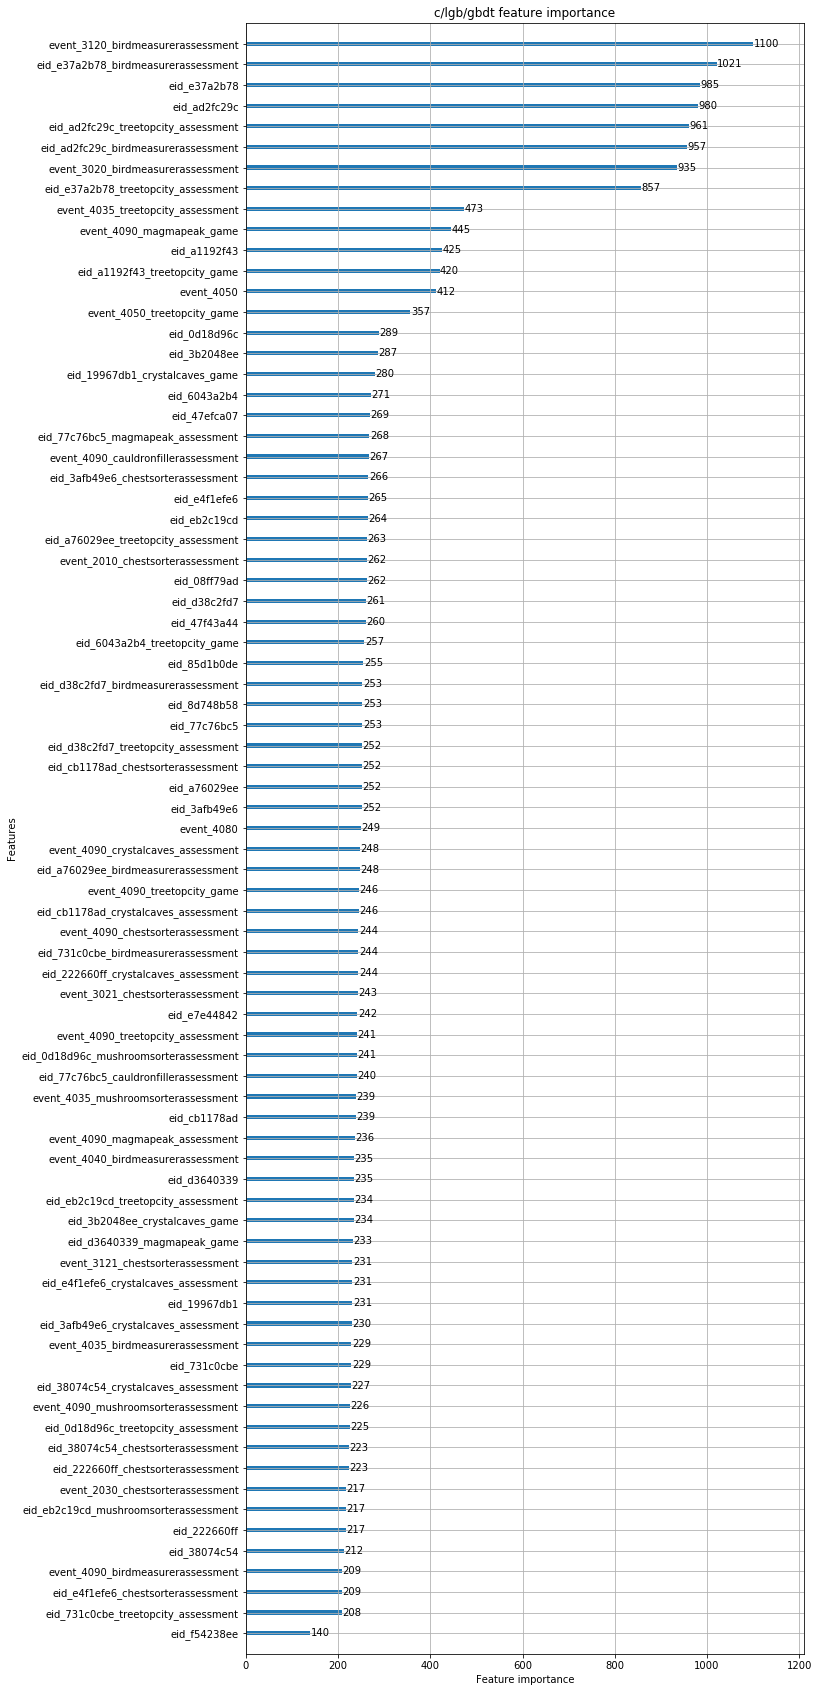

In [13]:
lgb.plot_importance(cls.best_estimator_['model'], max_num_features=100, figsize=(10, 30), title=f'{cls_name} feature importance')

In [14]:
%%time
clsd_name = 'c/lgb/dart'
model = lgb.LGBMClassifier(n_estimators=10000, reg_alpha=1, objective='binary', boosting_type='dart')
pipe = Pipeline([('model', model)])
param_grid = {
    'model__learning_rate': [0.001],
    'model__min_child_samples': [100],
    'model__colsample_bytree': [0.5]
}
clsd = GridSearchCV(pipe, cv=p_split, param_grid=param_grid, scoring='f1')
#cv.fit(x_train, y_train, model__early_stopping_rounds=200, model__verbose=500)
clsd.fit(x_train_cls, y_train_cls)
assert clsd.best_estimator_['model'].n_classes_ == 2
_log(f"""F1 {clsd_name}
best_score_={clsd.best_score_:.5f}
best_params_={clsd.best_params_}
n_features={clsd.best_estimator_['model'].n_features_}
""")

F1 c/lgb/dart
best_score_=0.90547
best_params_={'model__colsample_bytree': 0.5, 'model__learning_rate': 0.001, 'model__min_child_samples': 100}
n_features=4142

Wall time: 5min 21s


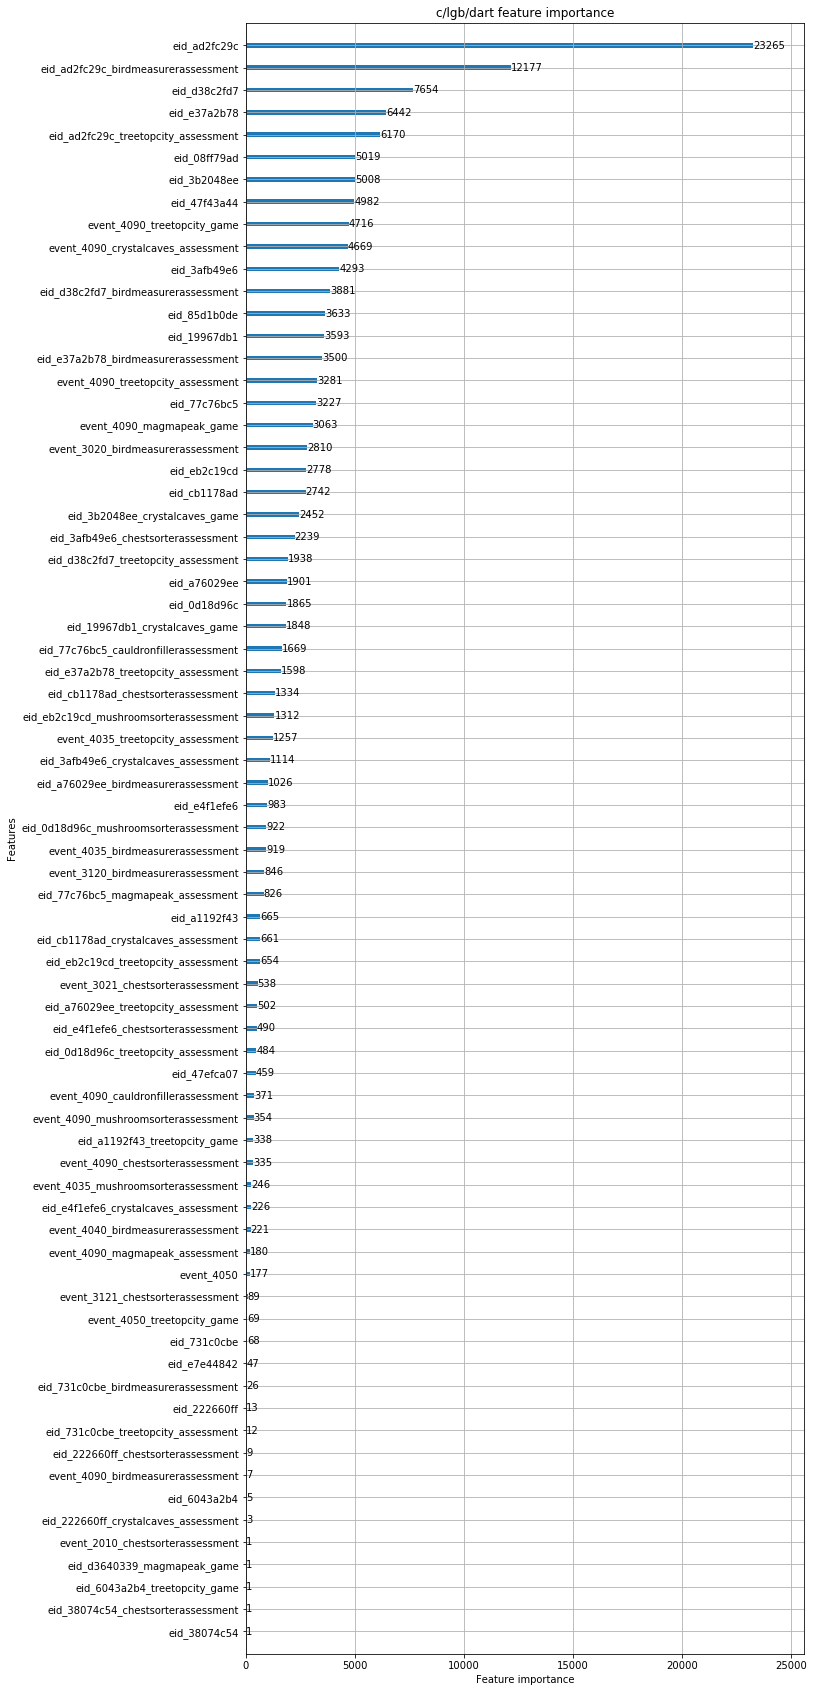

In [15]:
lgb.plot_importance(clsd.best_estimator_['model'], max_num_features=100, figsize=(10, 30), title=f'{clsd_name} feature importance')

In [16]:
%%time
def _random_forest_classifier(x_train_cls, y_train_cls):
    model = RandomForestClassifier(n_estimators=4000, max_features='log2')
    pipe = Pipeline([('model', model)])
    param_grid = {
        'model__max_depth': [4],
        'model__min_samples_leaf': [40]
    }
    rfc = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring='f1')
    rfc.fit(x_train_cls, y_train_cls)
    assert rfc.best_estimator_['model'].n_classes_ == 2
    return rfc


#rfc = _random_forest_classifier(x_train_cls, y_train_cls)
#_log(f"""F1 RandomForestClassifier
#best_score_={rfc.best_score_:.5f}
#best_params_={rfc.best_params_}
#n_features={rfc.best_estimator_['model'].n_features_}
#""")

Wall time: 0 ns


# Regression on the number of attempts to solve the assessment

In [17]:
def _rmse(y, y_pred):
    return sqrt(mean_squared_error(y, y_pred))


SCORING = make_scorer(_rmse, greater_is_better = False)

In [18]:
tmp = train[train['is_solved'] == 1]
y_train = tmp['solved_attempts']
x_train = tmp[PREDICTORS]
p_split = PredefinedSplit(test_fold=tmp['_is_val'].values)

split_df = tmp.groupby(['_is_val'], as_index=False)['installation_id'].count()
assert split_df.iloc[1]['installation_id'] >= 1500
split_df.head()

_is_val  installation_id
0       -1            11367
1        0             2094

In [19]:
%%time
cv_name = 'r/lgb/gbdt'
model = lgb.LGBMRegressor(n_estimators=10000, reg_alpha=1, boosting_type='gbdt')
pipe = Pipeline([('model', model)])
param_grid = {
    'model__learning_rate': [0.001],
    'model__min_child_samples': [100],
    'model__colsample_bytree': [0.1]
}
cv = GridSearchCV(pipe, cv=p_split, param_grid=param_grid, scoring=SCORING)
#cv.fit(x_train, y_train, model__early_stopping_rounds=200, model__verbose=500)
cv.fit(x_train, y_train)
_log(f"""RMSE {cv_name}
best_score_={cv.best_score_:.5f}
best_params_={cv.best_params_}
n_features={cv.best_estimator_['model'].n_features_}
""")

RMSE r/lgb/gbdt
best_score_=-0.67865
best_params_={'model__colsample_bytree': 0.1, 'model__learning_rate': 0.001, 'model__min_child_samples': 100}
n_features=4142

Wall time: 13 s


In [20]:
# plot_metric only works with early stopping rounds
#lgb.plot_metric(cv.best_estimator_['model'])

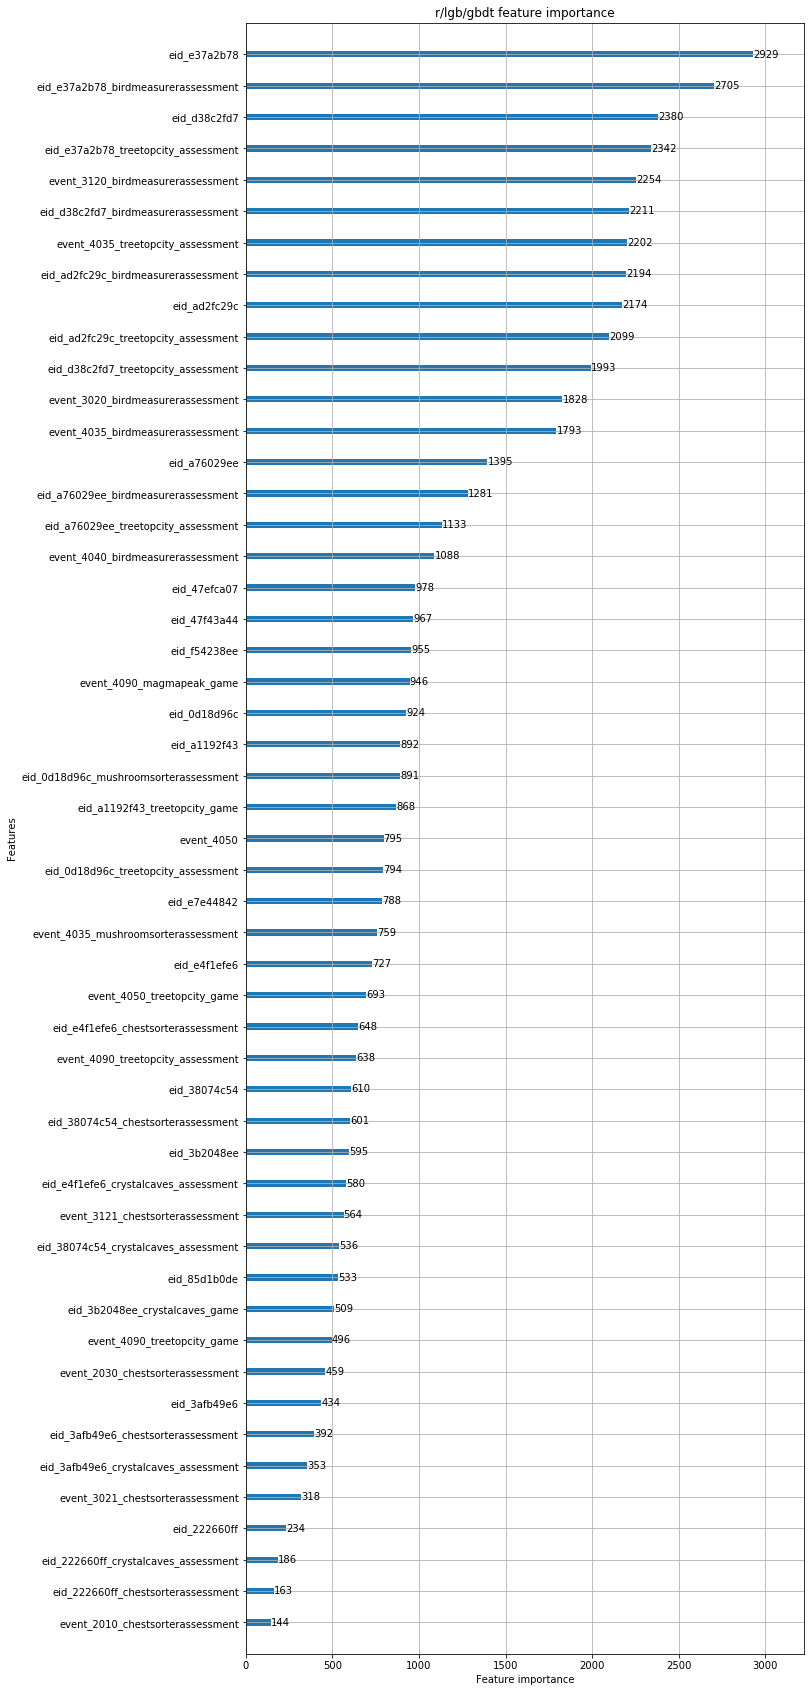

In [21]:
lgb.plot_importance(cv.best_estimator_['model'], max_num_features=100, figsize=(10, 30), title=f'{cv_name} feature importance')

In [52]:
%%time
cvd_name = 'r/lgb/dart'
model = lgb.LGBMRegressor(n_estimators=20000, reg_alpha=1, boosting_type='dart')
pipe = Pipeline([('model', model)])
param_grid = {
    'model__learning_rate': [0.001],
    'model__min_child_samples': [100],
    'model__colsample_bytree': [0.5]
}
cvd = GridSearchCV(pipe, cv=p_split, param_grid=param_grid, scoring=SCORING)
#cv.fit(x_train, y_train, model__early_stopping_rounds=200, model__verbose=500)
cvd.fit(x_train, y_train)
_log(f"""RMSE {cvd_name}
best_score_={cvd.best_score_:.5f}
best_params_={cvd.best_params_}
n_features={cvd.best_estimator_['model'].n_features_}
""")

RMSE r/lgb/dart
best_score_=-0.68483
best_params_={'model__colsample_bytree': 0.5, 'model__learning_rate': 0.001, 'model__min_child_samples': 100}
n_features=4142

Wall time: 3min 51s


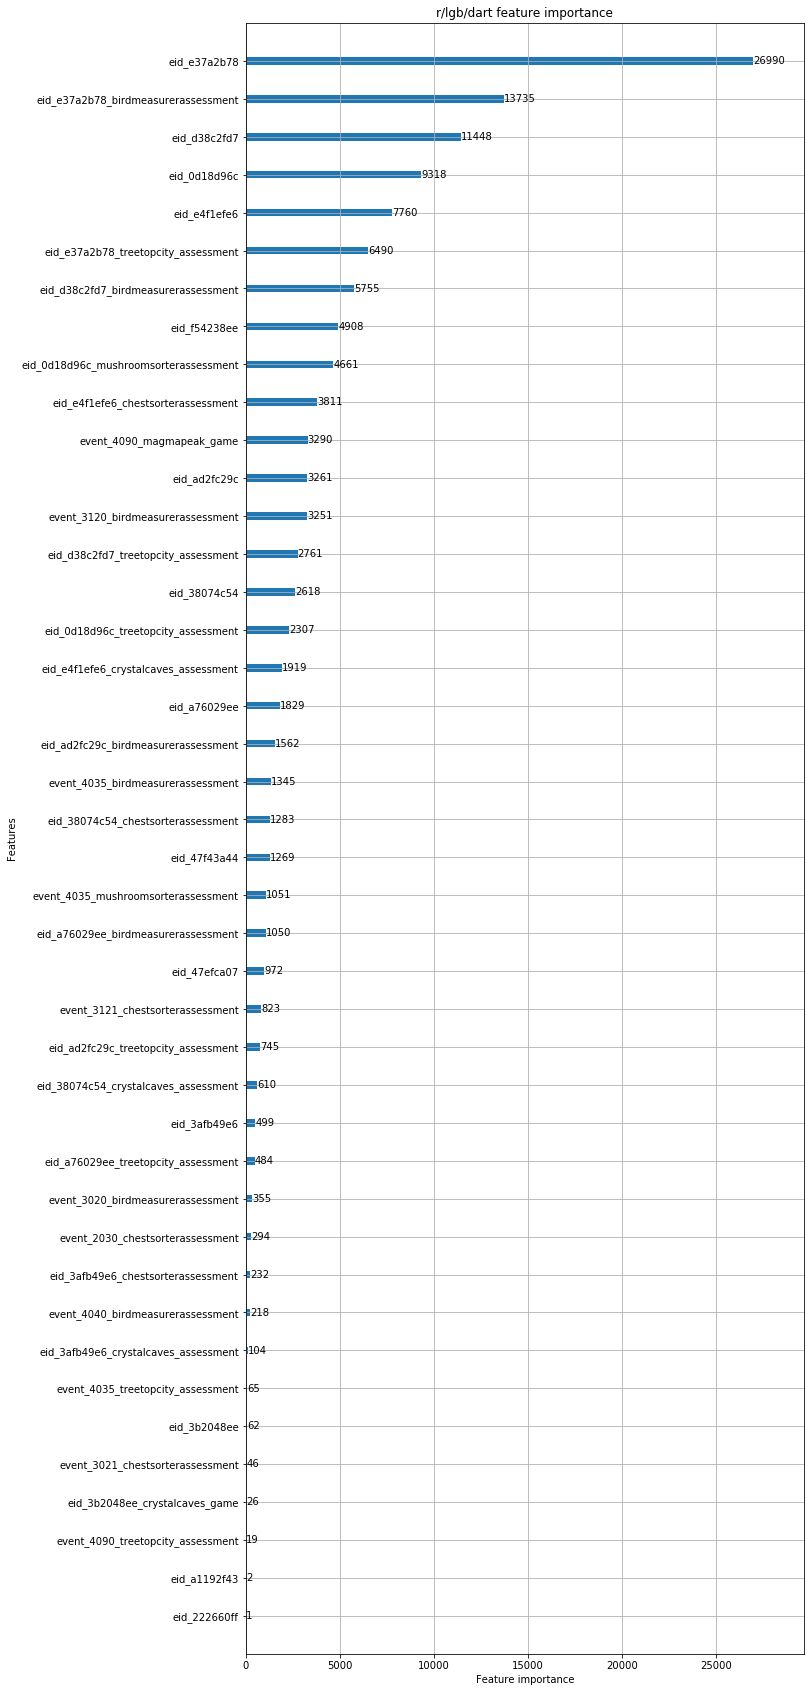

In [53]:
lgb.plot_importance(cvd.best_estimator_['model'], max_num_features=100, figsize=(10, 30), title=f'{cvd_name} feature importance')

In [54]:
%%time
def _random_forest_regressor(x_train, y_train):
    model = RandomForestRegressor(n_estimators=4000, max_features='log2')
    pipe = Pipeline([('model', model)])
    param_grid = {
        'model__max_depth': [4],
        'model__min_samples_leaf': [40]
    }
    rfr = GridSearchCV(pipe, cv=FOLDS, param_grid=param_grid, scoring=SCORING)
    rfr.fit(x_train, y_train)
    return rfr


#rfr = _random_forest_regressor(x_train, y_train)
#_log(f"""RMSE RandomForestRegressor
#best_score_={rfr.best_score_:.5f}
#best_params_={rfr.best_params_}
#n_features={rfr.best_estimator_['model'].n_features_}
#""")

Wall time: 0 ns


# Predict out of fold

In [139]:
%%time
BlendModel = namedtuple('BlendModel', ['model', 'name', 'weight'])

def _is_solved(score):
    if score >= 0.755:
        return 1
    return 0


def _solved_attempts(score):
    if score >= 2.2:
        return 3
    if score >= 1.35:
        return 2
    return 1


def _predict(df, classifiers, regressors):
    res = df[['installation_id']].copy()
    res[TARGET] = np.nan
    x_cls = df[PREDICTORS]
    res['is_solved'] = 0
    for m in classifiers:
        col = f'is_solved_{m.name}'
        res[col] = m.model.predict_proba(x_cls)[:,1]
        res['is_solved'] += res[col] * m.weight
    
    res['is_solved'] = np.int16(res['is_solved'].map(_is_solved))
    iids = set(res[res['is_solved'] == 1]['installation_id'].values)
    cols = ['installation_id'] + PREDICTORS
    tmp = df[df['installation_id'].isin(iids)][cols].copy()
    x = tmp[PREDICTORS]
    cols = ['installation_id', 'solved_attempts_raw', 'solved_attempts']
    tmp['solved_attempts_raw'] = 0
    for m in regressors:
        col = f'solved_attempts_{m.name}'
        cols.append(col)
        tmp[col] = m.model.predict(x)
        tmp['solved_attempts_raw'] += tmp[col] * m.weight
        
    tmp['solved_attempts'] = np.int16(tmp['solved_attempts_raw'].map(_solved_attempts))
    tmp = tmp[cols]
    res = res.merge(tmp, on='installation_id', how='left')
    res.loc[res['is_solved'] == 0, [TARGET]] = 0
    res.loc[(res['is_solved'] == 1) & (res['solved_attempts'] >= 3), [TARGET]] = 1
    res.loc[(res['is_solved'] == 1) & (res['solved_attempts'] == 2), [TARGET]] = 2
    res.loc[(res['is_solved'] == 1) & (res['solved_attempts'] <= 1), [TARGET]] = 3
    assert res[TARGET].notna().all(axis=None)
    res[TARGET] = np.int16(res[TARGET])
    return res


classifiers=[
    BlendModel(model=cls, weight=0.5, name=cls_name),
    BlendModel(model=clsd, weight=0.5, name=clsd_name)
]
regressors=[
    BlendModel(model=cv, weight=0.5, name=cv_name),
    BlendModel(model=cvd, weight=0.5, name=cvd_name)
]
oof = _predict(train, classifiers=classifiers, regressors=regressors)
oof.head(10)

Wall time: 22.7 s


installation_id  accuracy_group  is_solved  is_solved_c/lgb/gbdt  \
0      0006a69f_1               0          0              0.731064   
1      0006a69f_2               0          0              0.332696   
2      0006a69f_3               3          1              0.766697   
3      0006a69f_4               3          1              0.766697   
4      0006a69f_5               3          1              0.766697   
5      0006c192_1               3          1              0.766697   
6      0006c192_2               3          1              0.775638   
7      0006c192_3               1          1              0.932241   
8      00129856_1               3          1              0.766697   
9      001d0ed0_1               0          0              0.747279   

   is_solved_c/lgb/dart  solved_attempts_raw  solved_attempts  \
0              0.688329                  NaN              NaN   
1              0.205859                  NaN              NaN   
2              0.751209             1.311604              1.0   
3              0.751209             1.311604              1.0   
4              0.751209             1.311604              1.0   
5              0.751209             1.311604              1.0   
6              0.803241             1.313661              1.0   
7              0.982335             2.341234              3.0   
8              0.751209             1.311604              1.0   
9              0.687132                  NaN              NaN   

   solved_attempts_r/lgb/gbdt  solved_attempts_r/lgb/dart  
0                         NaN                         NaN  
1                         NaN                         NaN  
2                    1.349848                    1.273360  
3                    1.349848                    1.273360  
4                    1.349848                    1.273360  
5                    1.349848                    1.273360  
6                    1.353962                    1.273360  
7                    2.358530                    2.323938  
8                    1.349848                    1.273360  
9                         NaN                         NaN

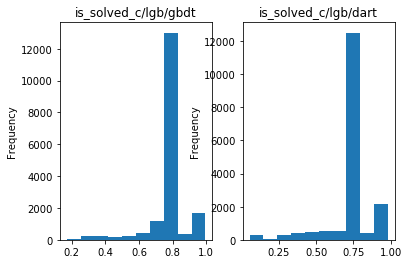

In [140]:
plt.subplot(1, 2, 1)
plt.title(f'is_solved_{cls_name}')
oof[f'is_solved_{cls_name}'].plot(kind='hist')
plt.subplot(1, 2, 2)
plt.title(f'is_solved_{clsd_name}')
oof[f'is_solved_{clsd_name}'].plot(kind='hist')

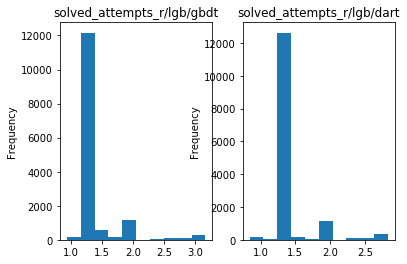

In [141]:
plt.subplot(1, 2, 1)
plt.title(f'solved_attempts_{cv_name}')
oof[f'solved_attempts_{cv_name}'].plot(kind='hist')
plt.subplot(1, 2, 2)
plt.title(f'solved_attempts_{cvd_name}')
oof[f'solved_attempts_{cvd_name}'].plot(kind='hist')

In [142]:
oof.sort_values(by=['installation_id'], inplace=True)
train.sort_values(by=['installation_id'], inplace=True)
y_true = train[TARGET]
y_pred = oof[TARGET]
kappa = cohen_kappa_score(y_true, y_pred, weights='quadratic')
acc = accuracy_score(y_true, y_pred)
_log(f'oof kappa={kappa:.5f}, acc={acc:.5f}')

oof kappa=0.31486, acc=0.55772


# Predict on Test set

In [143]:
%%time
sub = _predict(test, classifiers=classifiers, regressors=regressors)
sub = sub[['installation_id', TARGET]]
sample_sub = pd.read_csv(f'{INPUT_ROOT}/sample_submission.csv')
assert sub['installation_id'].equals(sample_sub['installation_id'])
sub.head()

Wall time: 4.86 s


installation_id  accuracy_group
0        00abaee7               3
1        01242218               0
2        017c5718               3
3        01a44906               2
4        01bc6cb6               3

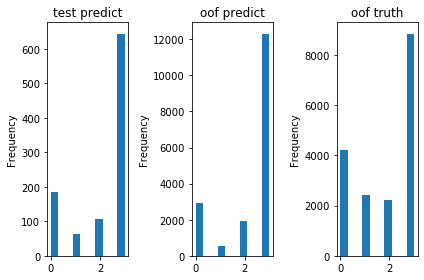

In [144]:
plt.subplot(1, 3, 1)
plt.title('test predict')
sub[TARGET].plot(kind='hist')
plt.subplot(1, 3, 2)
plt.title('oof predict')
oof[TARGET].plot(kind='hist')
plt.subplot(1, 3, 3)
plt.title('oof truth')
tmp = train[TARGET].copy()
tmp = tmp.astype(int)
tmp.plot(kind='hist')
plt.tight_layout()

In [145]:
sub.to_csv('submission.csv', index=False)
_log(os.listdir("."))

['.ipynb_checkpoints', 'dsbowl19-lgb.ipynb', 'dsbowl19-preprocess.ipynb', 'importances-01.png', 'lgbm_importances-01.png', 'submission.csv', 'test.parquet', 'test_scaled.parquet', 'train.parquet', 'train_scaled.parquet']
